# Facial Landmark Detection - Demonstration
Introduction to Deep Learning - Murphy, Aziha, Alaa  

_This demo is specifically meant to be run in Google Colab! You can find it [here](https://colab.research.google.com/github/StrangeGirlMurph/Facial-Landmark-Detection/blob/master/demo.ipynb)_

# Preparation

To work with the preprocessed data and pretrained models we will simply clone the GitHub repo and work from there.

In [1]:
!git clone https://github.com/StrangeGirlMurph/Facial-Landmark-Detection.git
%cd /content/Facial-Landmark-Detection/src
!git lfs pull

Cloning into 'Facial-Landmark-Detection'...
remote: Enumerating objects: 1684, done.
remote: Counting objects: 100% (401/401), done.
remote: Compressing objects: 100% (356/356), done.
remote: Total 1684 (delta 58), reused 376 (delta 45), pack-reused 1283
Receiving objects: 100% (1684/1684), 154.94 MiB | 29.42 MiB/s, done.
Resolving deltas: 100% (311/311), done.
/content/Facial-Landmark-Detection/src
Git LFS: (22 of 22 files) 792.96 MB / 792.96 MB


# Loading the data

In [2]:
from util.dataUtil import loadData, loadAugmentedData
import numpy as np

X_train, y_train = loadData(includeAugmented=False, includeTestData=False)
X_augmented, y_augmented = loadAugmentedData()

# The data should include the augmented data.
X = np.concatenate((X_train, X_augmented))
y = np.concatenate((y_train, y_augmented))


> Loading the data...


The dataset with the augmented data in total consists of 17749 96x96 images and their corresponding labels (15 landmarks with x,y-coordinates each):

In [3]:
X.shape, y.shape

((17749, 96, 96, 1), (17749, 30))

Keep in mind though that this data is already preprocessed and the labels include filling values (-1). The training data now consists of about 60% of augmented data.

# Visualizing the data

Let's look at some images and their landmarks.

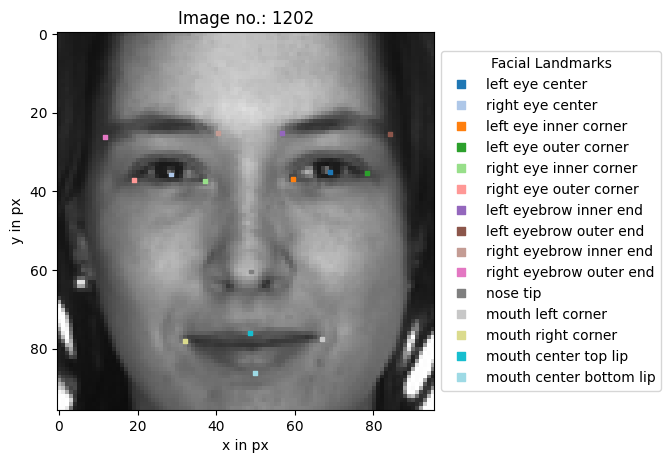

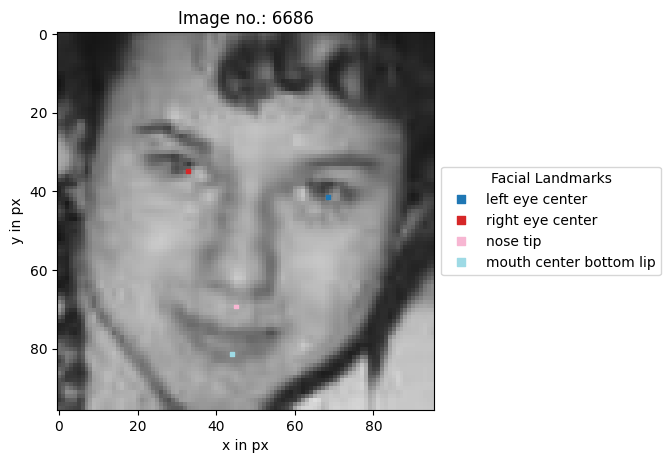

In [4]:
from util.plottingUtil import plotImageWithLabels
for i in [1202, 6686]:
  plotImageWithLabels(X[i], y[i], f"Image no.: {i}")

# Loading the trained model

In [5]:
from util.modelUtil import loadModel
modelV1 = loadModel("../models/modelV1") # for comparison
model = loadModel("../models/modelV4")


> Loading the model...

> Loading the model...


In [6]:
print("Loss:", model.loss.__name__)
print("Metrics:", model.metrics_names)
model.summary(line_length=100)

Loss: masked_mean_squared_error
Metrics: ['loss', 'masked_mean_absolute_error', 'masked_accuracy']
Model: "sequential"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 conv2d (Conv2D)                             (None, 96, 96, 32)                      288            
                                                                                                    
 leaky_re_lu (LeakyReLU)                     (None, 96, 96, 32)                      0              
                                                                                                    
 batch_normalization (BatchNormalization)    (None, 96, 96, 32)                      128            
                                                                                                    
 conv2d_1 (Conv2D)                           (None, 96, 96, 32)          

# Testing the model

## On the dataset itself

>>> Model V1 <<<

> Testing the model...


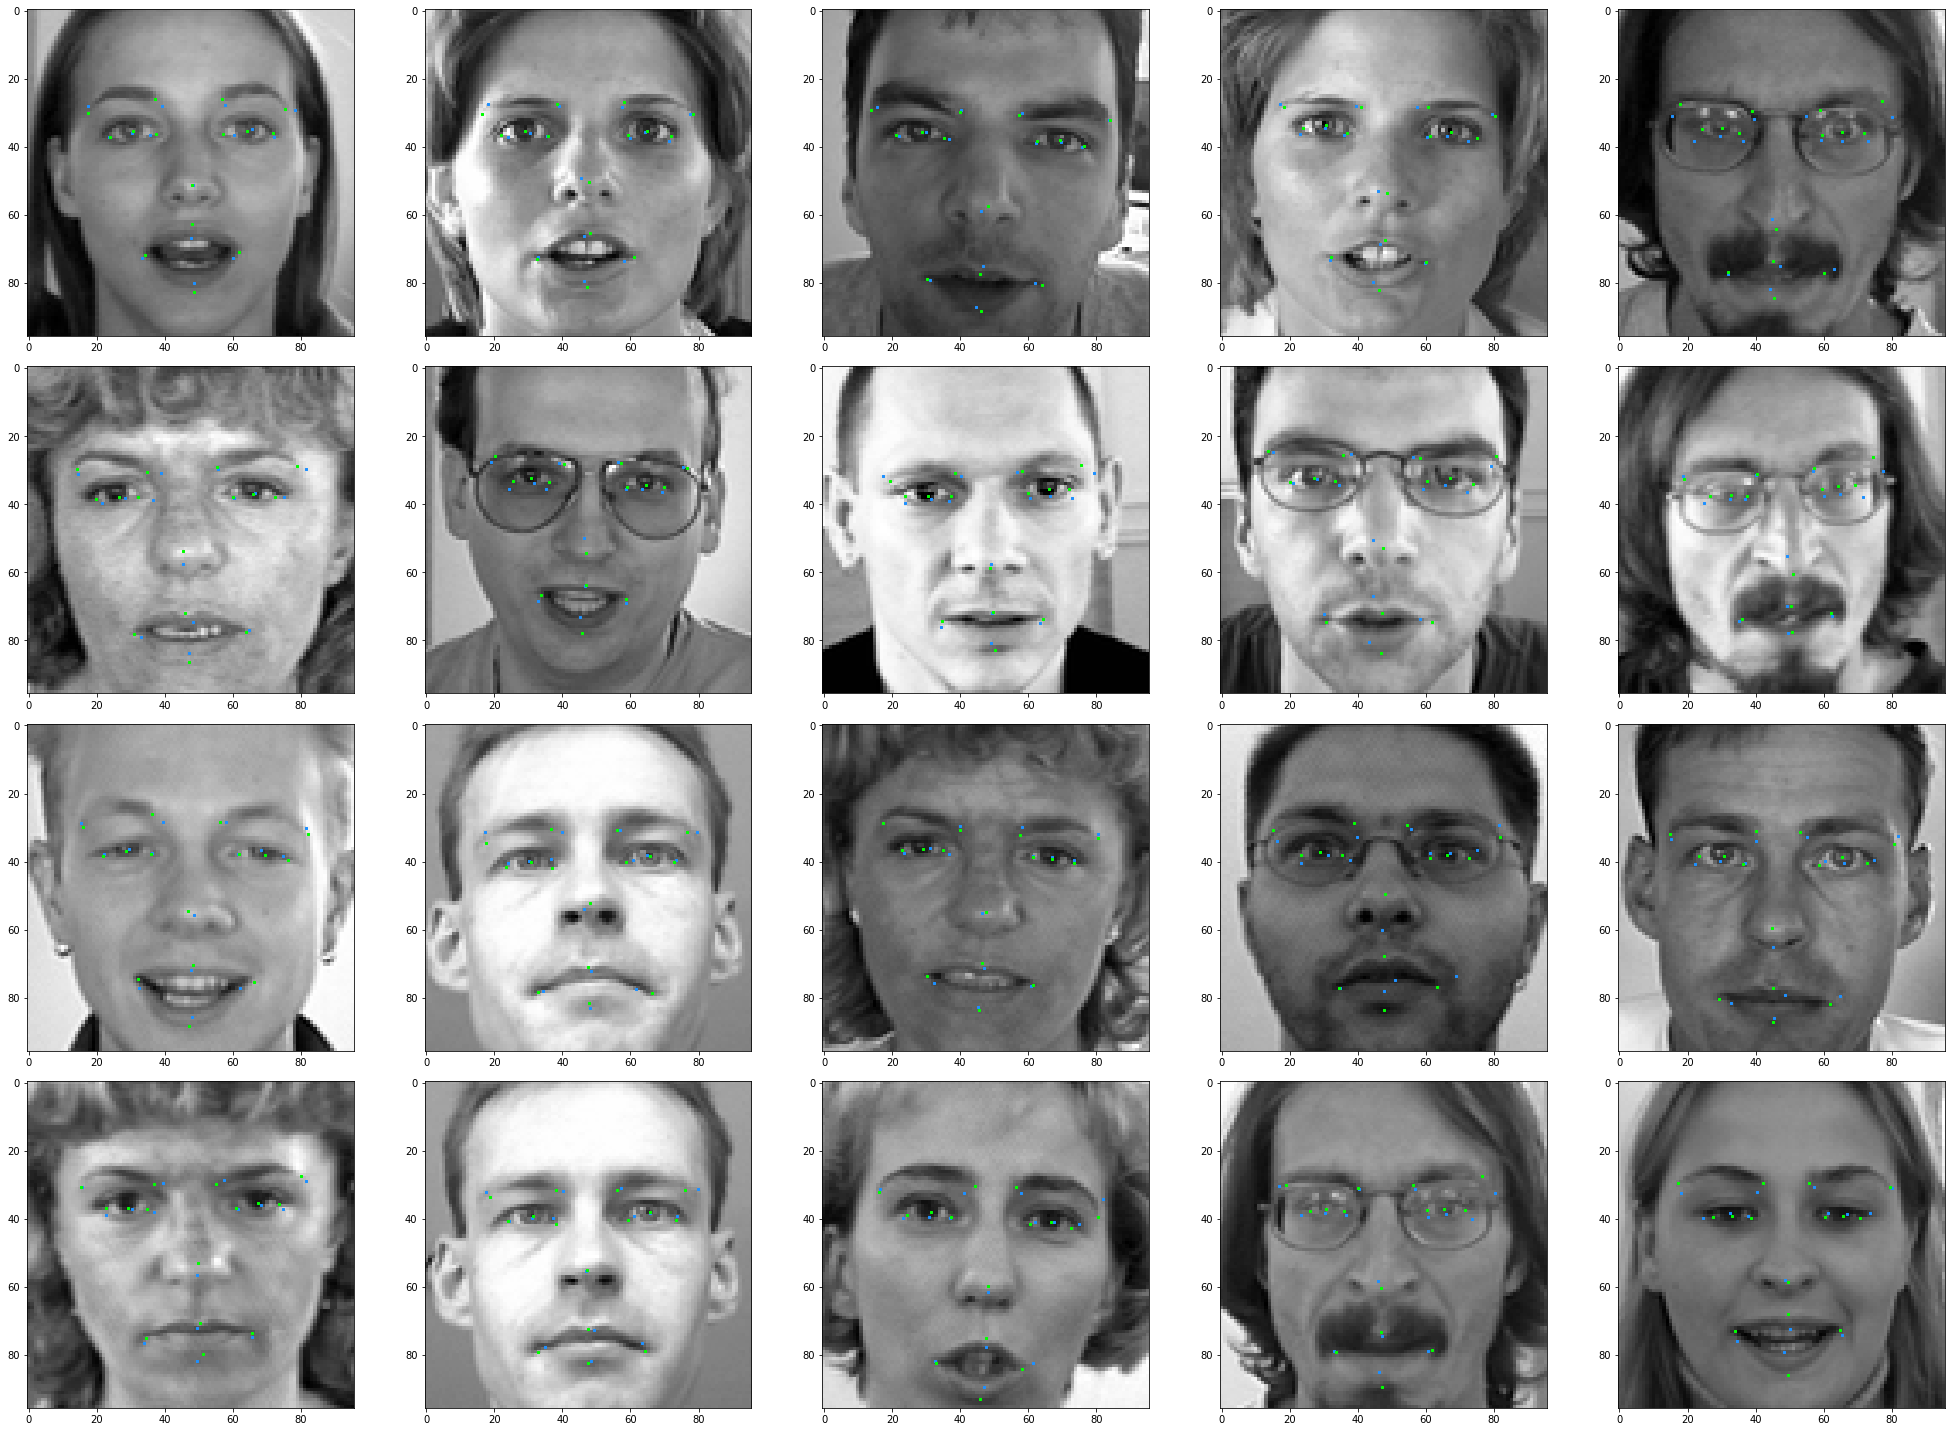



>>> Model V4 <<<

> Testing the model...


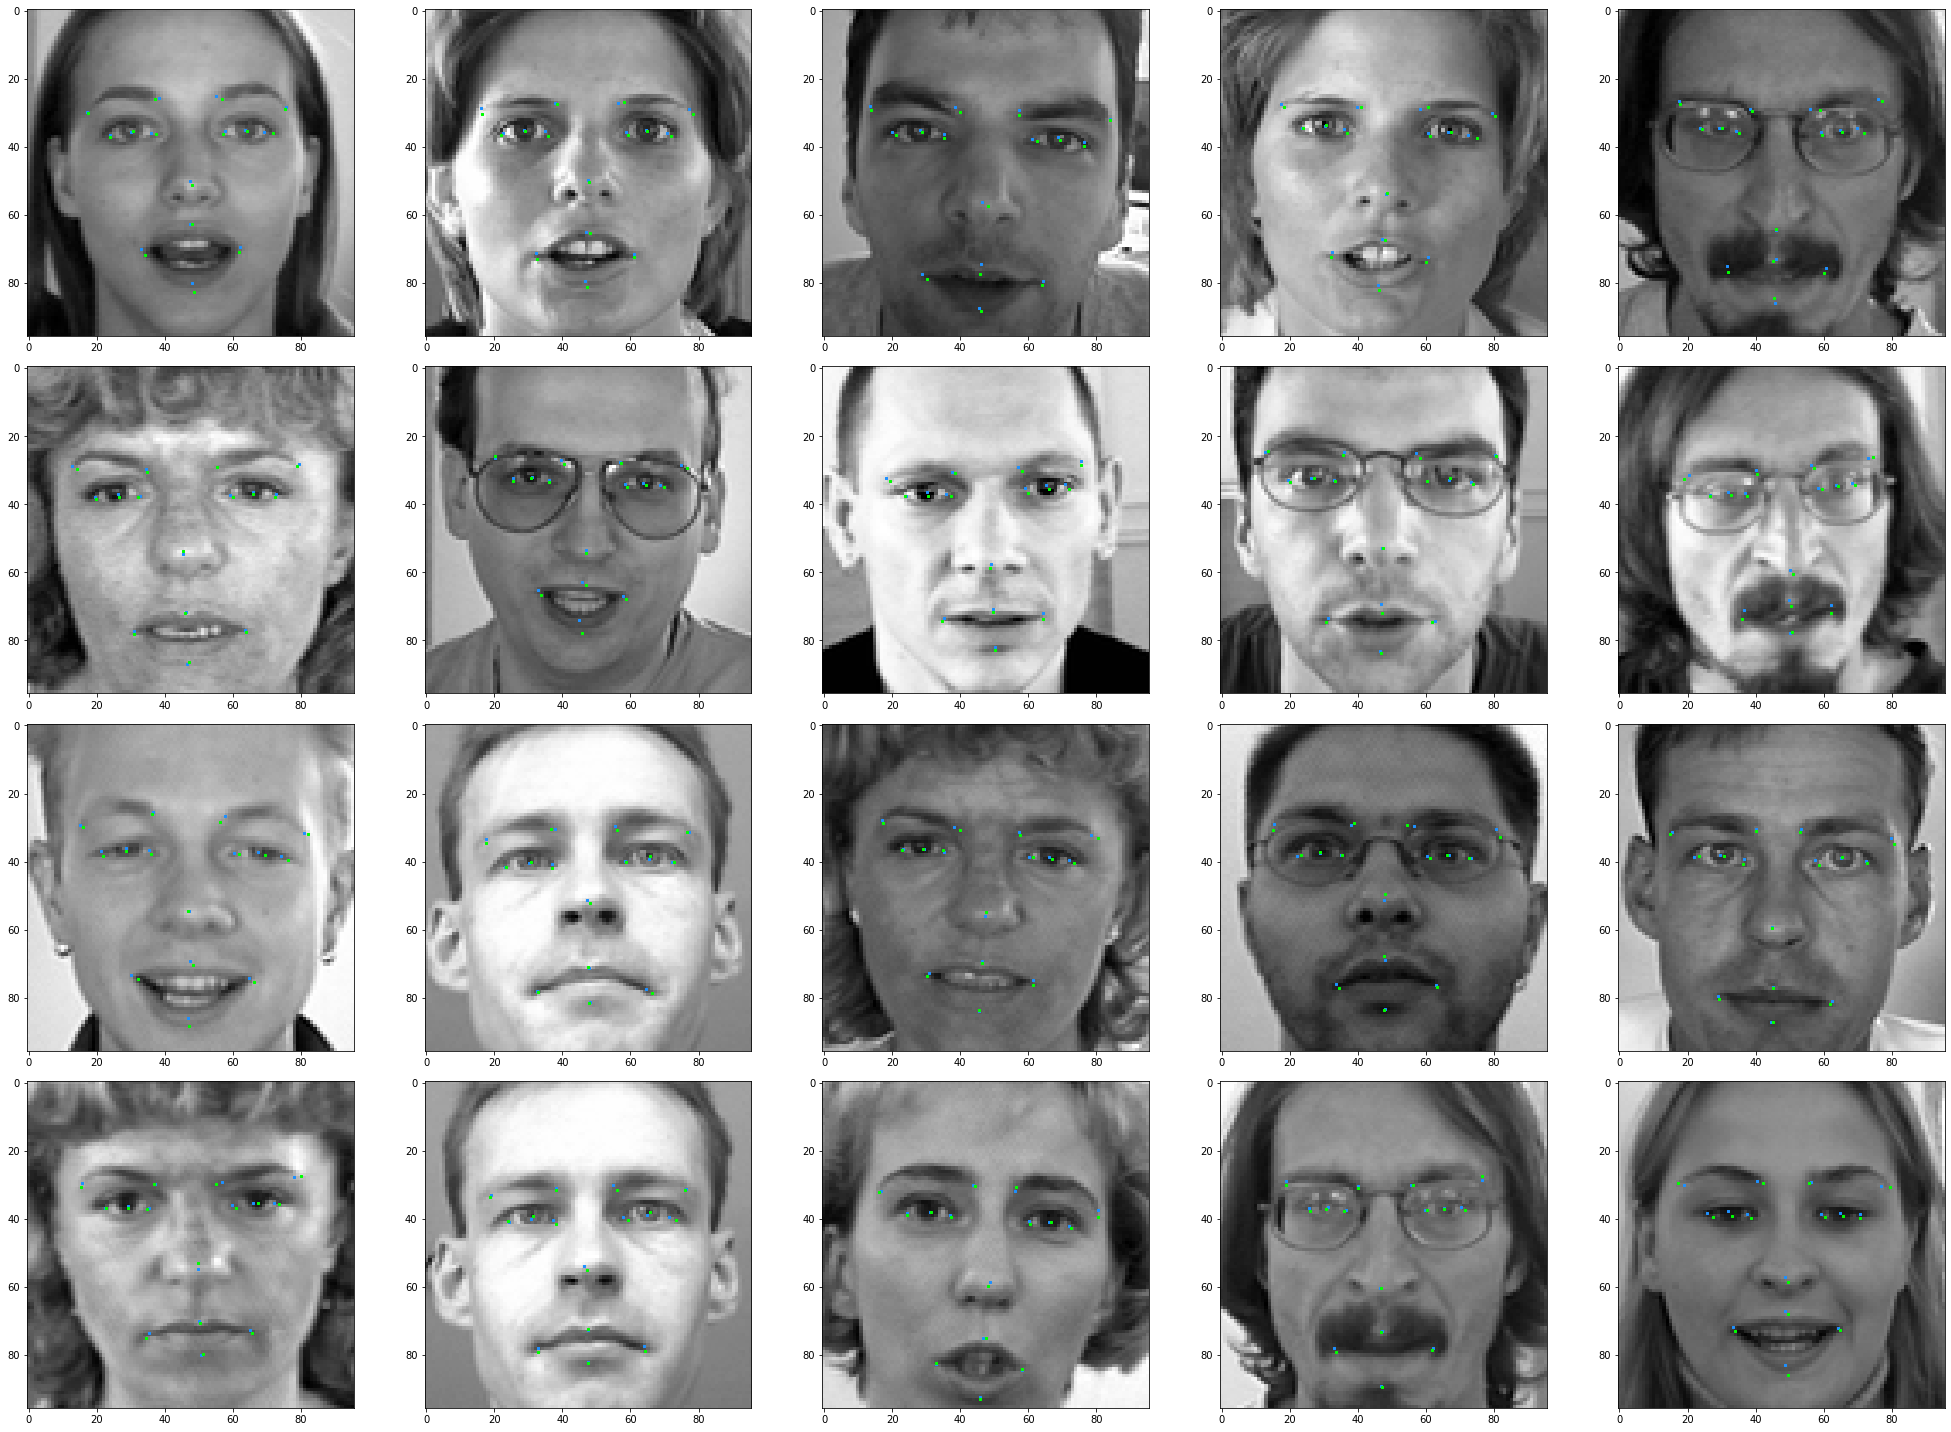

In [7]:
import matplotlib.pyplot as plt
from testing import testOnDataset

numberOfPoints, seed = 20, 30

print(">>> Model V1 <<<")
testOnDataset(modelV1, X_train[seed:seed+numberOfPoints], trueValues=y_train[seed:seed+numberOfPoints])
print("\n\n>>> Model V4 <<<")
testOnDataset(model, X_train[seed:seed+numberOfPoints], trueValues=y_train[seed:seed+numberOfPoints])

## On a video file

Sadly testing the model on the webcam feed directly doesn't work. It's way to slow.

In [18]:
from util.imageUtil import grayImage, mapPointsFromSquareToImage, resizeImageToModelSize, violaJones, violaJonesGetFaceCascade, drawPointsInImage, drawSquareInImage
from testing import predictOnImage
from tqdm import tqdm
import cv2 as cv

def testOnVideoFileColab(model, videoPath="../data/testVideos/406.avi", seconds=4):
    """Tests the model on a video file. (Minsize is the minimum size of the face in the image in %)"""
    print("\n> Testing the model on a video...")
    
    # hyperparameters to set yourself
    showFrame = True
    showPredImage = False # show the 96x96 image that gets predicted on
    minSize = 0.4
    
    # Face recognition
    c, r, s = 0, 0, 0  # face location (column, row, sideLength)
    faceCascade = violaJonesGetFaceCascade()
    faceRecognitionFrames = 10  # every nth frame is used for face recognition
    faceRecognitionCountdown = 5  # number of frames to wait before old data is discarded
    countdown = faceRecognitionCountdown
    faceFound = False
    frameCount = 0

    cap = cv.VideoCapture(videoPath)
    width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv.CAP_PROP_FPS))
    print(f"- Feed size: {width}x{height}")
    
    out = np.empty((0, height, width, 3), dtype=np.uint8)

    print(">> Predicting on the video...")
    for i in tqdm(range(fps * seconds)):
        if not cap.isOpened():
            break
        
        rv, frame = cap.read()
        if not rv:
            break

        im = grayImage(frame)

        if frameCount % faceRecognitionFrames == 0:
            faces = violaJones(im, faceCascade, int(min(width, height)*minSize))
            if len(faces) != 0:
                faceFound = True
                countdown = faceRecognitionCountdown
                c, r, s1, s2 = faces[0]
                s = max(s1, s2)
            else:
                if (countdown == 0):
                    faceFound = False
                else:
                    countdown -= 1

        if showPredImage:
            im = resizeImageToModelSize(im[r:r+s, c:c+s])
            if faceFound:
                x, y = predictOnImage(model, im)
                frame = drawPointsInImage(im[0], x, y)
            else:
                frame = im[0]
        else:
            if faceFound:
                im = resizeImageToModelSize(im[r:r+s, c:c+s])
                x, y = predictOnImage(model, im)
                x, y = mapPointsFromSquareToImage(x, y, c, r, s, width, height)
                frame = drawPointsInImage(frame, x, y)
                if showFrame:
                    frame = drawSquareInImage(frame, c, r, s)

        out = np.append(out, [frame], axis=0)

    cap.release()
    cv.destroyAllWindows()
    
    print(">> Writing the output video...")
    writer = cv.VideoWriter('output.mp4',cv.VideoWriter_fourcc(*'DIVX'), fps, (width, height))

    for i in tqdm(range(out.shape[0])):
        writer.write(out[i])
    writer.release()
    print("\n- Video made successfully!")

    return width

In [20]:
width = testOnVideoFileColab(model, "../data/testVideos/406.avi", seconds=10)


> Testing the model on a video...
- Feed size: 1280x720
>> Predicting on the video...


100%|██████████| 290/290 [00:48<00:00,  6.01it/s]


>> Writing the output video...


100%|██████████| 290/290 [00:01<00:00, 186.16it/s]


- Video made successfully!


In [28]:
from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = "output.mp4"

# Compressed video path
compressed_path = "output_compressed.mp4"

os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""<video width={width} controls><source src="{data_url}" type="video/mp4"></video>""")